> # Notebook para el EDA

In [1]:
# Librerias
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargando Yaml
with open("../config.yaml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

import warnings

# Ignora solo los avisos de funciones que van a cambiar en el futuro
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_excel(r"../Data/Base de datos MITOS.xlsx")

>> ## Exploración y Valores Nulos

Función para rellenar variables según lo estipulado por los compañeros de barcelona.

Se tomará el valor de la visita anterior correspondiente a cada ID. Esto hace sentido dado que en mediciones quimicas, los valores no suelen cambiar demasiado.
Además, que algunos de los nulos, se deben a que algunos estudios no se realizan si no ha pasado x numero de días, razón por la que no se realizó la medición en la visita siguiente.

In [3]:
def rellenar_nulos_por_id(df, lista_columnas):
    """
    Rellena nulos priorizando el valor de arriba (ffill) y luego el de abajo (bfill),
    estrictamente dentro del mismo grupo de id.
    """
    # Creamos una copia para no modificar el dataframe original directamente
    df_resultado = df.copy()

    # Agrupamos por ID para aislar los datos
    grupo = df_resultado.groupby('id')

    for col in lista_columnas:
        df_resultado[col] = grupo[col].transform(lambda x: x.ffill().bfill())

    return df_resultado

>>>### Parte I

Dado a que la investigación fue realizada dividiendo a los individuos en dos grupos, para aplicar 2 tratamientos distintos en 2 tiempos, revisaremos las siguientes columnas:

- visita
- grupo
- periodo
- tiempo
- tratamiento

Todos los individuos deberían de tener 4 visitas y un grupo, periodo y tiempo asignado. Las llamaremos **columnas identificadoras** pues únicamente sirven para identificar a los individuos así como a su tiempo/fase en el experimento.

In [4]:
# Contando registros por persona
df['visita'].value_counts().reset_index()

,visita,count
0,1,47
1,2,47
2,3,47
3,4,47


In [5]:
col_identificadoras = ['grupo', 'periodo', 'tiempo', 'tratamiento']

df[col_identificadoras].isna().sum()

grupo          6
periodo        8
tiempo         8
tratamiento    6
dtype: int64

In [6]:
df[df[col_identificadoras].isna().any(axis=1)]['id'].unique()

array([42, 46])

Podemos observar que los IDs 42 y 46 tienen valores nulos en las columnas identificadoras.

Dada la consulta con los compañeros de España, se decidió darles el siguiente tratamiento: **excluir a los individuos**

>>>### Parte II

Debido a que la base de datos se encuentra en un formato wide, lo transformaremos a uno deep para identificar si algún individuo no tiene alguna visita.

In [7]:
df_deep = df.copy()

# Eliminando columnas identificadoras para no confundirnos
df_deep.drop(columns=col_identificadoras,inplace=True)

# Transformando en formato deep
df_deep = pd.melt(df_deep, id_vars=['id', 'visita'], value_name='valor')

# Agrupando para encontrar nulos individuos sin ningun valor en una visita
df_visita_nula = df_deep.groupby(['id', 'visita'])['valor'].apply(lambda x: x.isnull().mean()).reset_index()

In [8]:
# Filtrando a los IDs que tengan visitas totalmente vacías
df_visita_nula[df_visita_nula.valor == 1]

,id,visita,valor
165,42,2,1.0
166,42,3,1.0
167,42,4,1.0
181,46,2,1.0
182,46,3,1.0
183,46,4,1.0


Podemos identificar a los individuos 8 y 26 que no tienen ningún valor en la cuarta visita.

Dada la consulta con los compañeros de España, se decidió darles el siguiente tratamiento: **excluir a los individuos**

In [9]:
# Excluyendo a los individuos que los compañeros nos indican, por ausencia total de información relevante.
df = df[~df['id'].isin([42, 46, 8, 26, 30])]

# Eliminando df_deep
del df_deep, df_visita_nula

In [10]:
nulls_count = df.isna().sum().reset_index()

nulls_count.columns = ['Variable','Null_Count']

In [11]:
nulls_count[nulls_count['Null_Count'] > 0]

,Variable,Null_Count
6,frec_alcohol_audit,128
7,puntaje_audit,128
8,Palabras_moca,126
9,memoria_moca,126
10,puntaje_moca,126
...,...,...
647,delta_d2_con_pd,84
648,delta_d2_vt_pd,84
649,delta_fn_nombre,84
650,delta_fn_score,84


>> ## Tratamiento de Variables y Valores Nulos

Tenemos **309** variables con valores nulos.

Dada nuestra conversación con los compañeros de Barcelona, nos juntamos para definir que tratamiento darles a los valores nulos de cada variable.

Aprovechando que colaboramos con expertos en el tema, pudimos tomar una decisión precisa para cada una de ellas.
Se optó por eliminar ciertas variables que no estaban muy completas o que ellos no consideraron relevantes para el estudio.

Algunas otras se les dará tratamiento especial y en otras llenaremos los valores nulos con la técnica que se mencionará a continuación.

>>> ### Tratamiento **Especial**

Estas variables, recibimos instrucciones especiales para tratar con ellas o con los valores nulos, a continuación el detalle por variable.

    EDAD
Dado que esta columna solamente tiene una observación por Id, la rellenaremos con la fecha de nacimiento del mismo individuo.

In [12]:
# Rellenando
df['f_nac'] = df['f_nac'].ffill()

# Posteriormente, se nos indicó calcular la edad al momento de la visita. Se calculará a 2 decimales.
df['edad'] = ((pd.to_datetime(df['fecha_visita']) - pd.to_datetime(df['f_nac'])).dt.days / 365).round(2)

# Eliminando Fecha de Nacimiento
del df['f_nac']

    MEDICAMENTOS
Estas variables, tienen de manera escrita que medicamentos usa, se contará cuántos usa y se transformará a nulos para eliminar el resto.

In [13]:
df = df.copy()
# Extrayendo variables del config
med_columns = config['Tratamiento_Variables']['Especial'][1:7]

# Cuenta solo si NO es nulo Y ademas NO es una cadena vacía
df['total_meds'] = (df[med_columns].notna()).sum(axis=1)

# No se eliminarán las columnas, pues están dentro del listado de eliminar y se hará de manera masiva en una instrucción abajo.
del med_columns

    MENSTRUACION
Para las variables de menstruación, se eliminarán las fechas y creará una variable categórica.

Las categorías serán las siguientes:

- MEF: Mujeres en Edad Fértil (o Edad Reproductiva).
- MPM: Mujeres Postmenopáusicas.
- H: Hombres.

In [14]:
# Rellenando la variable sexo, pues esta solo tiene un registro por id
df = rellenar_nulos_por_id(df, ['sexo'])

In [15]:
min_f_visita = min(pd.to_datetime(df['fecha_visita']))
max_f_visita = max(pd.to_datetime(df['fecha_visita']))

# Extrayendo las variables del config
menst_columns = config['Tratamiento_Variables']['Especial'][7:9]

# Convirtiendo a fechas
df[menst_columns] = df[menst_columns].apply(pd.to_datetime, errors='coerce')
# Validando fechas de menstruación
condicion_c1 = df[menst_columns[0]].between(min_f_visita, max_f_visita)
condicion_c2 = df[menst_columns[1]].between(min_f_visita, max_f_visita)

# Creando flag de menstruación
df['menst_flag'] = (condicion_c1 | condicion_c2).astype(int)

# Validando una vez más, que en hombres sea 0 la columna
df.loc[df['sexo'] == 1, 'menst_flag'] = 0

# Creando variable categórica menst_tipo
condiciones = [
    (df['sexo'] == 1), 
    (df['sexo'] == 2) & (df['menst_flag'] == 1),
    (df['sexo'] == 2) & (df['menst_flag'] == 0)
]

resultados = ['Hombre', 'MEF', 'MPM']

# Aplicación
df['menst_tipo'] = np.select(condiciones, resultados, default='No clasificado')

# Eliminando las variables que no se utilizarán
df.drop(columns=menst_columns)
del min_f_visita, max_f_visita, menst_columns

    NUMERO DEPOSICIONES
Se estandarizará a valores: 'Una Por Día', '< Una Por Día', 'Dos + Por Día'

In [16]:
# Variable numero de deposiciones

# Investigando valores únicos
df.num_depo.unique()

array([nan, '1/día', '1-2/dia', '6/semana', '5/semana', 'cada 2 días',
       '2/día', 'Diariamente', '3/día', '1-2/día', 'diariamente',
       '2-3/día', 'Diariamente, hasta 2/día', '5/setmana', '4/setmana',
       '4/semana', '2/dia', 'Cada 2 días', '4veces/semana',
       '4 veces/semana', '3 veces/semana', 'Cada 2-3 días',
       '1-2 veces/día',
       'Última semana a diario. Anteriormente cada 4 días',
       'Cada 4-5 días', '1 vez/semana', '2 veces/semana', '2 veces/día',
       '1/día, a veces 2', '2-3 veces/día'], dtype=object)

In [17]:
# Creando diccionario con valores únicos
depo_dict = {
    '1/día': 'Una Por Día', 
    '1-2/dia': 'Dos + Por Día', 
    '6/semana': '< Una Por Día', 
    '5/semana': '< Una Por Día', 
    'cada 2 días': '< Una Por Día',
    '2/día': 'Dos + Por Día', 
    'Diariamente': 'Una Por Día', 
    '4/semana': '< Una Por Día', 
    '3/día': 'Dos + Por Día', 
    '1-2/día': 'Dos + Por Día', 
    'diariamente': 'Una Por Día', 
    '2-3/día': 'Dos + Por Día', 
    'Diariamente, hasta 2/día': 'Dos + Por Día', 
    '5/setmana': '< Una Por Día', 
    '4/setmana': '< Una Por Día', 
    '2/dia': 'Dos + Por Día', 
    'Cada 2 días': '< Una Por Día', 
    '6/setmana': '< Una Por Día', 
    '1/dia': 'Una Por Día', 
    '4veces/semana': '< Una Por Día', 
    '4 veces/semana': '< Una Por Día', 
    '3 veces/semana': '< Una Por Día', 
    'Cada 2-3 días': '< Una Por Día', 
    '1-2 veces/día': 'Dos + Por Día', 
    'Última semana a diario. Anteriormente cada 4 días': 'Una Por Día', 
    'Cada 4-5 días': '< Una Por Día', 
    '1 vez/semana': '< Una Por Día', 
    '2 veces/semana': '< Una Por Día', 
    '2 veces/día': 'Dos + Por Día', 
    '1/día, a veces 2': 'Dos + Por Día', 
    '2-3 veces/día': 'Dos + Por Día'
}

df['num_depo'] = df.num_depo.map(depo_dict)

In [18]:
# Rellenando los valores nulos en la variable num_depo
df = rellenar_nulos_por_id(df, ['num_depo'])

    OBSERVACIONES
Se estandarizará a valores: si o no.

In [19]:
# Los nulos significa no tienen observaciones
df['observaciones'].fillna('No',inplace=True)

# Rellenando cambiando las observaciones con Si
df.loc[df['observaciones'] != 'No', 'observaciones'] = 'Si'

    pgh_5j
En esta variable, los missings significan 0. (La única en todo el dataset).

In [20]:
df['pgh_5j'].fillna(0,inplace=True)

    VARIABLES DE CONSUMO DE TOMATE
Son las variables correspondientes al consumo de tomate, se tiene un valor por id, pues se refiere a la cantidad de tomate durante el tratamiento de consumo.

In [21]:
# Seleccionando variables de tomate del cofig
tomate_columns = config['Tratamiento_Variables']['Especial'][12:]

# Se rellenará primero con el más cercano
df = rellenar_nulos_por_id(df, tomate_columns)

# Por último, se rellenará con 0 los nulos, dado que los nulos ahora significan que no consumieron ese tipo de tomate
df[tomate_columns] = df[tomate_columns].fillna(0)

del tomate_columns

    VARIABLES ANALISIS DE ORINA CON SIGNOS +
Son las variables correspondientes a análisis clínicos, entre más signos de + tenga, significa más contenido de analito.

La recomendación del compañero fue:  negativo o trazas = 0 y positivo = 1.

In [22]:
# Definiendo las columnas diferentes a aplicar este tratamiento
orina_columns = ['hemoglobina_orina','leucocitos_orina','nitritos_orina','albumina_orina','bilirrubina_orina','cetonas_orina','urobilinogeno_orina','glucosa_orina']

# Rellenando los valores faltantes
df = rellenar_nulos_por_id(df, orina_columns)

# Extrayendo valores únicos de las variables.
orina_unicos = []

for col in orina_columns:
    orina_unicos.extend(df[col].unique())

# Imprimiendo valores únicos para asignarles valor
print(orina_unicos)

['negativo', 'Negatiu ', 'Negatiu', 'traces', 'Traces', 'positivo(+)', 'positivo(+++)', '(+)', '(++)', 'negativo', 'positivo(+)', 'positivo(++++)', 'Negatiu', 'positivo(+++)', 'Positivo(+++)', 'positiu(+)', 'positiu(++/A)', '(+)', 'positivo(++)', '(++++)', '(+)/A', 'negativo', 'positivo(+)', 'Negatiu', 'negativo', 'Negatiu', 'traces', 'negativo', 'Negatiu', 'negativo', 'Negatiu', 'traces', 'Traces', 'positivo(+)', 'positivo', 'postivo(+)', 'negativo', 'Negatiu']


In [23]:
# Construyendo lista con remplazo de los valores
orina_values = [0,0,0,0,0,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0]

# Creando diccionario para mapear los valores
orina_dict = dict(zip(orina_unicos,orina_values))

# Remplazando los valores
df[orina_columns] = df[orina_columns].replace(orina_dict)

del orina_columns, orina_dict, orina_values

    VARIABLES ANALISIS DE SEDIMENTOS CON SIGNOS +
Son las variables correspondientes a análisis clínicos de sedimentos.

La recomendación del compañero fue:  rellenar los nulos con la palabra 'Ausente'. También se traducirán las palabras en catalán.

In [24]:
# Definiendo las columnas diferentes a aplicar este tratamiento
sed_columns = ['hematies_sed','leucocitos_sed','bacterias_sed','celulas_epiteliales_sed','cilindros_hialinos_sed','precipitados_urat_sed','oxalato_calcico_sed','fibra_mucoide_sed']

# Rellenando los valores nulos
df[sed_columns] = df[sed_columns].fillna('Ausente')

# Rellenando los valores faltantes
df = rellenar_nulos_por_id(df, sed_columns)

# Extrayendo valores únicos de las variables.
sed_unicos = []

for col in sed_columns:
    sed_unicos.extend(df[col].unique())
sed_unicos = list(set(sed_unicos))

# Imprimiendo valores únicos para asignarles valor
print(sed_unicos)

['(20-35)', 'Abundant', 'Negatiu', '(5-10)', 'escasos', 'Moderades', 'traces', 'Moderado', 'Moderados', '(1-5)', '(1-3)', '(3-5)', 'negativo', 200, 'Moderada', '(100-150)', '(35-60)', 'negatiu', '(25-30)', 'Escasos', 'Ausente', '(10-20)']


In [25]:
# Construyendo lista con remplazo de los valores
sed_values = ['Moderado', 'Moderado', '(1-5)', 'Negativo', '(100-150)', 'Escaso', '(5-10)', '(20-35)', '(1-3)', 'Abundante', 'Moderado', 'Escaso', 200, 'Negativo', '(25-30)', 'Negativo', 'Moderado', 'Negativo', '(35-60)', '(10-20)', 'Ausente', '(3-5)']

# Creando diccionario para mapear los valores
sed_dict = dict(zip(sed_unicos,sed_values))

# Remplazando los valores
df[sed_columns] = df[sed_columns].replace(sed_dict)

del sed_columns, sed_dict, sed_values

>>> ### Tratamiento **Eliminar Variables**

Estas variables, recibimos instrucciones de eliminarlas, pues se cambiaron por otras o estaban mayormente nulas.

In [26]:
# Obteniendo listado de variables a eliminar
eliminar_columns = config['Tratamiento_Variables']['Eliminar']

df = df.drop(columns=eliminar_columns)

print(f'Dadas las instrucciones de nuestros compañeros, se eliminaron: {len(eliminar_columns)} variables.')

del eliminar_columns

Dadas las instrucciones de nuestros compañeros, se eliminaron: 145 variables.


>>> ### Tratamiento **Replicar**

Estas variables, se registró su valor únicamente en el primer renglón de cada individuo, pues son datos como sexo, etc. que nunca cambian.

In [27]:
# Replicando valor por id
df = rellenar_nulos_por_id(df, config['Tratamiento_Variables']['Replicar'])

>>> ### Tratamiento **Rellenar más cercano**

Ciertas variables químicas presentan valores ausentes debido a los protocolos de medición, los cuales exigen un intervalo temporal específico (X días) entre muestras; en consecuencia, algunas visitas sucesivas no cumplieron con dicho criterio. De forma marginal, se registraron nulos por incidencias técnicas en el procesamiento de laboratorio. 

Para asegurar la integridad del análisis, se aplicó una imputación mediante el método de **last observation carried forward (LOCF)** o, en su defecto, el valor de la visita inmediata posterior.

In [28]:
# Replicando valor por id
df = rellenar_nulos_por_id(df, config['Tratamiento_Variables']['Rellenar_Cercano'])

In [29]:
# Exportando CSV y excel con datos manipulados
df.to_csv('../Data/Final_DF.csv',index=False)
df.to_excel('../Data/Final_DF.xlsx',index=False)

>> ## Estadísticas de Variables

In [30]:
# Leyendo el archivo de variables procesadas
df = pd.read_excel(r'../Data/Final_DF.xlsx')

Calculando estadísticas de las variables categóricas nominales.

In [31]:
df.describe(include=['object', 'category']).T

,count,unique,top,freq
hematies_sed,168,7,Ausente,134
leucocitos_sed,168,8,Ausente,133
bacterias_sed,168,5,Ausente,138
celulas_epiteliales_sed,168,5,Ausente,147
cilindros_hialinos_sed,168,1,Ausente,168
precipitados_urat_sed,168,2,Ausente,167
oxalato_calcico_sed,168,5,Ausente,163
fibra_mucoide_sed,168,4,Ausente,157
num_depo,168,3,Una Por Día,96
tmb,168,152,1351,3


Calculando estadísticas de las variables numéricas

In [32]:
df.describe(include=['float']).T

,count,mean,std,min,25%,50%,75%,max
frec_alcohol_audit,160.0,2.250000,1.115922,0.000000,2.0000,2.00000,3.000000,4.00
puntaje_audit,160.0,3.200000,2.256507,0.000000,2.0000,3.00000,4.000000,12.00
edad,168.0,47.468036,4.710542,40.020000,43.5625,46.37500,51.585000,56.64
tipo_alcohol,144.0,2.722222,1.265157,1.000000,2.0000,2.00000,4.000000,4.00
frec_alcohol,164.0,1.219512,0.683269,0.000000,1.0000,1.00000,2.000000,3.00
...,...,...,...,...,...,...,...,...
cv_social_relationships_100,168.0,62.822420,20.171612,8.333333,50.0000,66.66666,75.000000,100.00
cv_enviroment_100,168.0,70.153061,16.704134,25.000000,59.3750,71.87500,81.250000,100.00
hads_score,168.0,9.517609,6.425059,0.000000,5.0000,8.00000,13.000000,36.00
horas_cama,168.0,7.798413,1.052518,5.166667,7.0000,7.50000,8.354166,12.25


Describiendo las variables categóricas ordinales.

In [33]:
df.describe(include=['int']).T

,count,mean,std,min,25%,50%,75%,max
id,168.0,23.238095,13.420530,1.0,12.00,22.5,35.00,47.0
visita,168.0,2.500000,1.121376,1.0,1.75,2.5,3.25,4.0
grupo,168.0,1.428571,0.496351,1.0,1.00,1.0,2.00,2.0
periodo,168.0,1.500000,0.501495,1.0,1.00,1.5,2.00,2.0
tiempo,168.0,1.500000,0.501495,1.0,1.00,1.5,2.00,2.0
...,...,...,...,...,...,...,...,...
pgh_duracion_sueño,168.0,1.250000,0.880596,0.0,1.00,1.0,2.00,3.0
pgh_total,168.0,6.059524,3.543912,1.0,4.00,5.0,8.00,17.0
cat_pgh_total,168.0,1.422619,0.495453,1.0,1.00,1.0,2.00,2.0
total_meds,168.0,0.494048,1.173546,0.0,0.00,0.0,0.00,6.0


>> ## Variables Con Sesgo

Dado que tenemos más de 300 variables numéricas (no categóricas), calcularemos primero el sesgo para filtrar a las que realmente presentan una distribución sesgada.
De esta manera, no haremos gráficos con tantas variables y nos permitirá hacer una interpretación solo de las necesarias.

In [34]:
# Captura float64, int64, etc.
numeric_vars = df.select_dtypes(include='float').columns.tolist()

In [46]:
numeric_vars = df.describe(include=['float']).columns.tolist()
# Calculando el sesgo de todas las variables numéricas. Utilizamos el valor absoluto para incluir las más sesgadas en ambos lados.
skew_series = df[numeric_vars].skew().abs().sort_values(ascending=False)
df_skew = pd.DataFrame({'Sesgo':skew_series})
print(f'Graficaremos unicamente a las variables con sesgo >= 1.5 ({df_skew[df_skew['Sesgo'] >= 1.5].shape[0]} variables.)')

Graficaremos unicamente a las variables con sesgo >= 1.5 (141 variables.)


In [48]:
# Determinando variables a graficar
skew_vars = df_skew[df_skew['Sesgo'] >= 1.5].index.tolist()

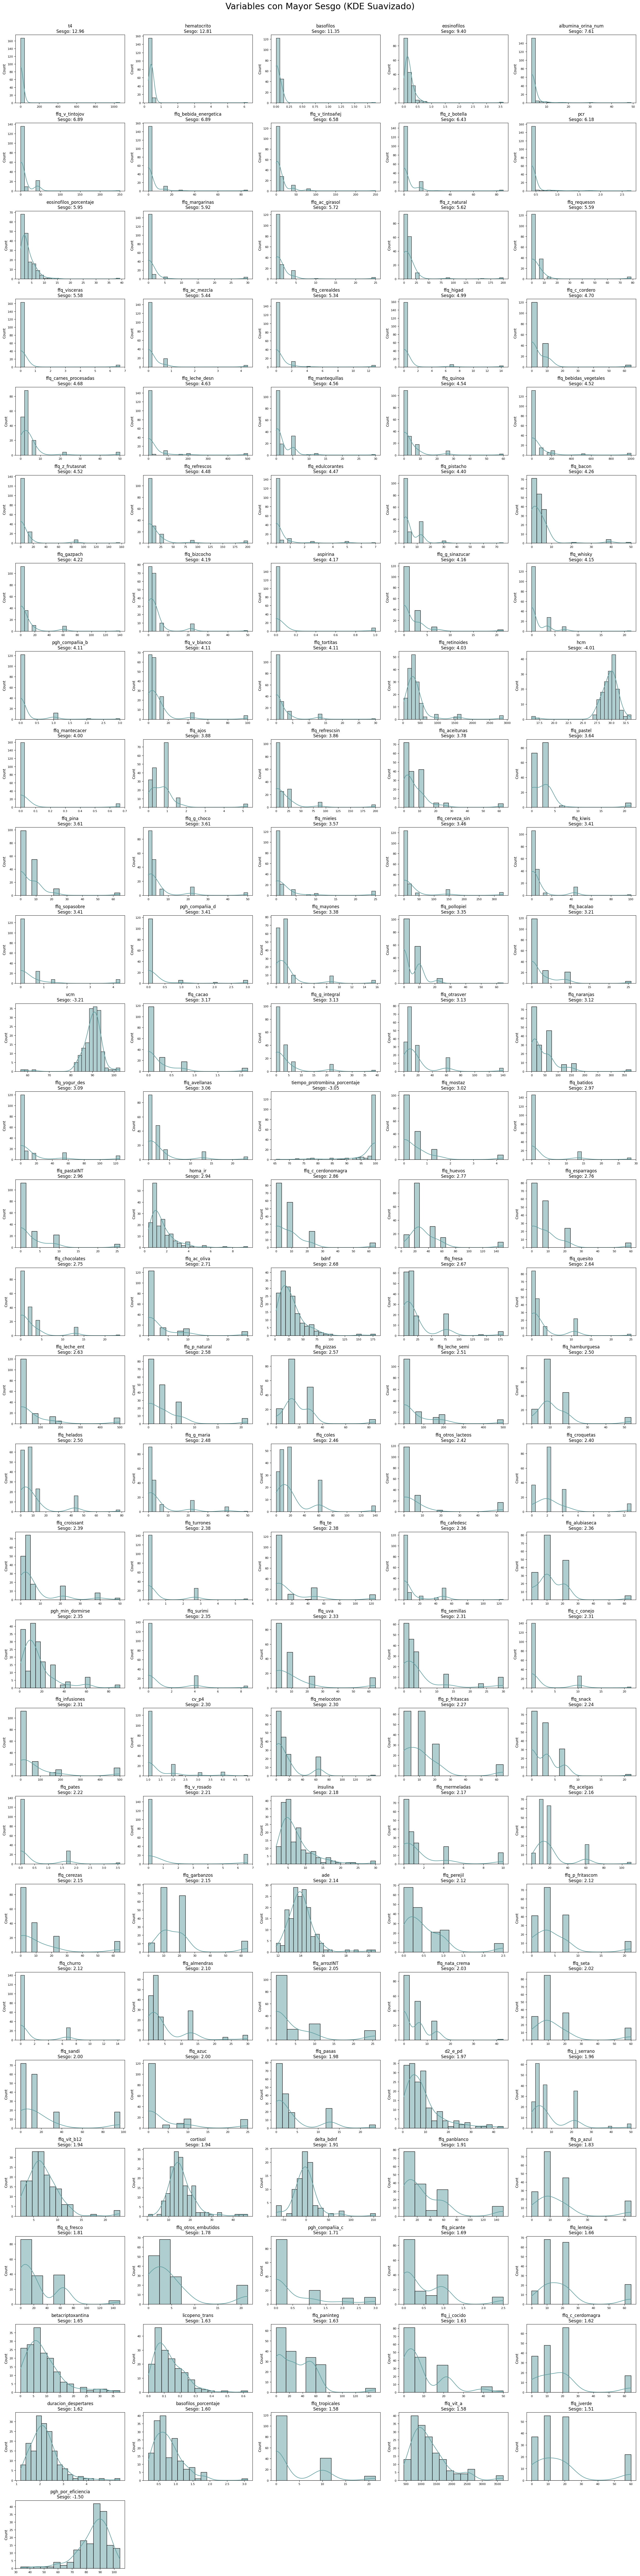

In [57]:
# Aumentamos el alto (figsize) a 100 para que cada gráfico tenga espacio vertical
fig, axes = plt.subplots(29, 5, figsize=(25, 100))
fig.suptitle('Variables con Mayor Sesgo (KDE Suavizado)', fontsize=24, y=1.002)

# Aplanamos la matriz de ejes para iterar fácilmente
axes_flat = axes.flatten()

for i, col in enumerate(skew_vars):
    # Graficar en el eje correspondiente
    sns.histplot(data=df, x=col, kde=True, ax=axes_flat[i], color='cadetblue')
    
    # Personalización de cada celda
    current_skew = df[col].skew()
    axes_flat[i].set_title(f"{col}\nSesgo: {current_skew:.2f}", fontsize=12)
    axes_flat[i].set_xlabel('')
    axes_flat[i].tick_params(labelsize=8)

# Ocultamos ejes sobrantes si hay menos variables
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

## 🛠️ Tratamiento de Asimetría y Estrategia de Interpretabilidad

Se han identificado **141 variables** con un coeficiente de asimetría ($\gamma \ge 1.5$). Dada la naturaleza del problema, donde la **interpretabilidad** es un requisito indispensable, la estrategia de transformación debe permitir la reversibilidad de los datos para comunicar hallazgos en las unidades originales.


---

En la siguiente entrega del proyecto, estaremos explorando transformaciones como:

### 1.1 Logaritmo Natural ($log1p$)
Para mitigar el sesgo sin destruir la estructura relacional de los datos, aplicaremos la transformación:
$$y = \ln(x + 1)$$

### 1.2 Yeo-Johnson
A diferencia de Box-Cox, **Yeo-Johnson** es una transformación de potencia que admite valores cero y negativos, lo cual es vital en datos clínicos donde podemos tener cambios netos o indicadores basales de cero.

$$
\psi(\lambda, x) = 
\begin{cases} 
((x+1)^\lambda - 1)/\lambda & \text{si } \lambda \neq 0, x \geq 0 \\
\ln(x+1) & \text{si } \lambda = 0, x \geq 0 
\end{cases}
$$

---

### 2. El Desafío de la Interpretabilidad Post-Modelado
Transformar 141 variables mejorará el rendimiento del modelo, pero dificulta la lectura de las predicciones. Para mantener la interpretabilidad una vez finalizado el modelo, sugerimos las siguientes acciones:

* **Inversa de la Función (Back-transformation):** Al presentar resultados finales o predicciones, aplicaremos la función inversa para devolver el valor a su unidad original.
* **Análisis de Importancia con SHAP:** Utilizaremos valores SHAP para explicar la contribución de cada variable. Aunque la variable esté en escala logarítmica, el impacto relativo sigue siendo válido para identificar los principales "drivers" del fenómeno.
* **Gráficos de Dependencia Parcial (PDP):** Generaremos curvas de respuesta re-escalando el eje X a las unidades originales para que los stakeholders puedan leer el valor real de la variable.

---
